# Betabinomial mixture model for detecting mitochondria variants

In [1]:
import bbmix
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt

In [2]:
AD = mmread("../../vireo/data/mitoDNA/cellSNP.tag.AD.mtx").tocsc().toarray()
DP = mmread("../../vireo/data/mitoDNA/cellSNP.tag.DP.mtx").tocsc().toarray()
AD.shape, DP.shape

((9, 81), (9, 81))

### Run on all variants

In [3]:
from bbmix.models import MixtureBetaBinomial

model1 = MixtureBetaBinomial(n_components = 1, max_m_step_iter=250, tor=1e-20)
model2 = MixtureBetaBinomial(n_components = 2, max_m_step_iter=250, tor=1e-20)

for i in range(AD.shape[0]):
    a = AD[i, :]
    d = DP[i, :]
    idx = d >= 10
    a, d = a[idx], d[idx]
    
    params1 = model1.EM((a, d), max_iters=500, init_method="mixbin", early_stop=True)
    params2 = model2.EM((a, d), max_iters=500, init_method="mixbin", early_stop=True)
    p_val = bbmix.models.LR_test(model1.losses[-1] - model2.losses[-1], df = 3)
    print(i, "mode1: %.2f\tmodel2:%.2f\tp: %.3e" %(model1.losses[-1], model2.losses[-1], p_val))

0 mode1: 3770.12	model2:3771.16	p: 1.000e+00
1 mode1: 158788.35	model2:158781.11	p: 2.335e-03
2 mode1: 6842.48	model2:6842.48	p: 1.000e+00
3 mode1: 18809.12	model2:18805.48	p: 6.367e-02
4 mode1: 85475.22	model2:85425.78	p: 2.691e-21
5 mode1: 18101.26	model2:18049.43	p: 2.533e-22
6 mode1: 10071.81	model2:10009.56	p: 8.265e-27
7 mode1: 4634.41	model2:4633.51	p: 6.133e-01
8 mode1: 4436.28	model2:4436.29	p: 1.000e+00


### Test variant 1

In [4]:
from bbmix.models import MixtureBetaBinomial

model1 = MixtureBetaBinomial(n_components = 1, max_m_step_iter=250, tor=1e-20)
model2 = MixtureBetaBinomial(n_components = 2, max_m_step_iter=250, tor=1e-20)

In [5]:
i = 1
idx = DP[i, :] >= 0
a = AD[i, idx]
d = DP[i, idx]
a, d

(array([ 757, 1389, 1848, 2786,  840,    0, 3235,  556,    0,    0, 1481,
           0,    0,    0, 2309,  975, 2906, 1373,    0, 2350, 1079,  702,
           0, 1170,    2,    0, 1326,  747,   79,   84,   73,  106,   85,
          70,   52,  121,  121,   84,   96,   96,   84,   53,   68,   75,
         102,   52,   54,  101,   84,   98,   70,   47,  117,   85,   57,
         103,  122,   89,   30,   57,   88,   91,  129,   62,   47,   54,
          62,  105,   66,   77,   92,   46,   71,   70,   76,   90,   89,
         111,   97,   84,   73], dtype=int64),
 array([56285, 57048, 85197, 75299, 70820,     1, 70177, 59266,     2,
            1, 52240,     0,     0,     2, 69510, 61508, 65161, 49149,
            4, 54536, 48494, 42745,     1, 57212,   259,     2, 39498,
        52364, 74127, 57890, 63668, 64624, 71265, 52303, 55123, 74667,
        54405, 56676, 55460, 54653, 55798, 55346, 56837, 70769, 61141,
        50395, 39744, 56247, 55498, 59498, 51857, 48345, 66227, 70626,
        6

In [6]:
# Multiple initializations

for ite in range(5):
    params1 = model1.EM((a, d), max_iters=500, init_method="mixbin", early_stop=True)
    params2 = model2.EM((a, d), max_iters=500, init_method="mixbin", early_stop=True)

    p_val = bbmix.models.LR_test(model1.losses[-1] - model2.losses[-1], df = 3)
    print(i, "mode1: %.2f\tmodel2:%.2f\tp: %.3e" %(model1.losses[-1], model2.losses[-1], p_val))

1 mode1: 158823.45	model2:158823.34	p: 9.759e-01
1 mode1: 158822.30	model2:158817.79	p: 2.900e-02
1 mode1: 158821.43	model2:158820.11	p: 4.489e-01
1 mode1: 158825.16	model2:158823.36	p: 3.087e-01
1 mode1: 158821.52	model2:158820.00	p: 3.868e-01


### Calibration of p value - mixture of betabinomial

In [7]:
from bbmix.models import MixtureBetaBinomial

model1 = MixtureBetaBinomial(n_components = 1, max_m_step_iter=250, tor=1e-20)
model2 = MixtureBetaBinomial(n_components = 2, max_m_step_iter=250, tor=1e-20)

model0 = MixtureBetaBinomial(n_components = 1, max_m_step_iter=250, tor=1e-20)
params0 = model0.EM((a, d), max_iters=500, init_method="mixbin", early_stop=True)

In [8]:
n_iter = 100
p_vals = np.ones(n_iter)

for ite in range(n_iter):
    a_sim = model0.sample(d)
    params1 = model1.EM((a_sim, d), max_iters=500, init_method="mixbin", early_stop=True)
    params2 = model2.EM((a_sim, d), max_iters=500, init_method="mixbin", early_stop=True)
    p_vals[ite] = bbmix.models.LR_test(model1.losses[-1] - model2.losses[-1], df = 3)

Text(0.5, 1.0, 'QQ plot from Null model')

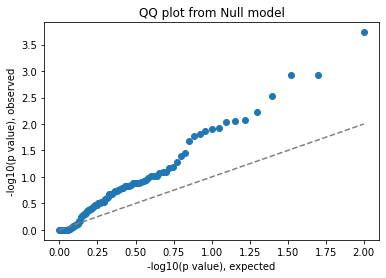

In [9]:
plt.plot(-np.log10(np.linspace(0, 1, len(p_vals)+1)[1:]), 
         -np.sort(np.log10(p_vals)), 'o')
plt.plot([0, np.log10(len(p_vals))], 
         [0, np.log10(len(p_vals))], '--', color='grey')
plt.xlabel("-log10(p value), expected")
plt.ylabel("-log10(p value), observed")
plt.title("QQ plot from Null model")

### Calibration of p value - mixture of binomial

In [10]:
from bbmix.models import MixtureBinomial

model1 = MixtureBinomial(n_components = 1, tor=1e-20)
model2 = MixtureBinomial(n_components = 2, tor=1e-20)

model0 = MixtureBinomial(n_components = 1, tor=1e-20)
params0 = model0.EM((a, d), max_iters=500, early_stop=True)

In [11]:
n_iter = 100
p_vals = np.ones(n_iter)

for ite in range(n_iter):
    a_sim = model0.sample(d)
    params1 = model1.EM((a_sim, d), max_iters=500, early_stop=True)
    params2 = model2.EM((a_sim, d), max_iters=500, early_stop=True)
    p_vals[ite] = bbmix.models.LR_test(model1.losses[-1] - model2.losses[-1], df = 3)

In [12]:
model1.losses[-1], model2.losses[-1]

(342.01161072104173, 342.01161072104173)

Text(0.5, 1.0, 'QQ plot from Null model')

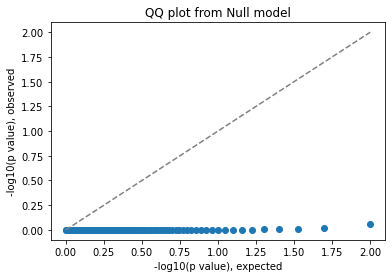

In [13]:
plt.plot(-np.log10(np.linspace(0, 1, len(p_vals)+1)[1:]), 
         -np.sort(np.log10(p_vals)), 'o')
plt.plot([0, np.log10(len(p_vals))], 
         [0, np.log10(len(p_vals))], '--', color='grey')
plt.xlabel("-log10(p value), expected")
plt.ylabel("-log10(p value), observed")
plt.title("QQ plot from Null model")